This is a modified LAGO pipeline for demostrating a concept. User can set privacy and utility goals based on their use case. For simplicity purposes the target parameters can range from 0-1 and actually the privacy metric is just NewRowSynthesis metric and the utility is just the SPECKS metric. The library module generates set number of datasets and chooses the closest dataset to desired targets.

In [ ]:
sg_package = ['synthguard'] # replace with synthguard git repo


In [2]:
from kfp import dsl
from kfp.compiler import Compiler
from kfp import components as comp
from typing import NamedTuple

# Load Data

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import synthguard.helper_functions as sd
from synthguard.input_handler import InputHandler


# from input_handler import InputHandler

INPUT_PATH = './../../../code/synthetic_data_tool/datasets/tabular/cyber/LAGO/elamislubade_taotlused.csv'

# input handler
inputHandler = InputHandler()
inputHandler.load_data_csv("https://opendata.smit.ee/ppa/csv/elamislubade_taotlused.csv", 1000)
# input_handler.load_data_csv(file_path=INPUT_PATH)
input_data = inputHandler.data
input_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Taotluse reg.kpv,Elamisloa liik,Rändeliik,Kodakondsus,Sugu,Vanuserühm
0,2015-01-02 00:00:00.0,Tähtajaline elamisluba,Pereränne,Ukraina,N,35-39
1,2015-01-02 00:00:00.0,Tähtajaline elamisluba,Pereränne,Ukraina,N,70-74
2,2015-01-02 00:00:00.0,Tähtajaline elamisluba,Töötamine,India,M,20-24
3,2015-01-02 00:00:00.0,Tähtajaline elamisluba,Töötamine,India,M,25-29
4,2015-01-02 00:00:00.0,Tähtajaline elamisluba,Töötamine,Venemaa,M,50-54
...,...,...,...,...,...,...
995,2015-02-10 00:00:00.0,Tähtajaline elamisluba,Välisleping,Määratlemata kodakondsus,M,35-39
996,2015-02-10 00:00:00.0,Tähtajaline elamisluba,Välisleping,Venemaa,N,35-39
997,2015-02-10 00:00:00.0,Tähtajaline elamisluba,Välisleping,Venemaa,N,60-64
998,2015-02-10 00:00:00.0,Tähtajaline elamisluba,Õppimine,Ukraina,M,15-19


## KFP Component

In [3]:
def input_real_data(output_csv: comp.OutputPath('csv')):
	import synthguard.helper_functions as sd
	from synthguard.input_handler import InputHandler
	print('Started loading data')
	#Component logic
	inputHandler = InputHandler()
	inputHandler.load_data_csv("https://opendata.smit.ee/ppa/csv/elamislubade_taotlused.csv", 1000)
	print('Finished loading data')
	input_data = inputHandler.data
	sd.save_to_csv(input_data, output_csv)

# Compiling funtion into a KFP component
input_component = comp.create_component_from_func(func = input_real_data, base_image = 'python:3.10', packages_to_install = sg_package)

Error when stripping type annotations: No module named 'lib2to3'


# Preprocess Data

In [13]:
import synthguard.helper_functions as sd
from synthguard.data_preprocessor import DataPreprocessor

dataPreprocessor = DataPreprocessor(data = input_data)
processed_data, metadata = dataPreprocessor.preprocess_data()


Preprocessing data. Data shape: (1000, 6)
Preprocessing complete.


## KFP Component

In [4]:
def preprocess(input_csv: comp.InputPath('csv'), output_json: comp.OutputPath('json')):
    import synthguard.helper_functions as sd
    from synthguard.data_preprocessor import DataPreprocessor

    #Component logic
    input_data = sd.load_data_csv(input_csv)
    dataPreprocessor = DataPreprocessor(data = input_data)

    processed_data, metadata = dataPreprocessor.preprocess_data()
    sd.save_metadata(metadata, output_json)

# Compiling funtion into a KFP component
preprocess_component = comp.create_component_from_func(func = preprocess, base_image = 'python:3.10', packages_to_install = sg_package)


Error when stripping type annotations: No module named 'lib2to3'


# Synthetic Data Generation using CopulaGANSynthesizer

In [ ]:
# from synthetic_data_generator import SyntheticDataGenerator
import synthguard.helper_functions as sd
from synthguard.synthetic_data_generator import SyntheticDataGenerator



OutputCSV = 'elamislubade_taotlused_synthetic.csv'
output_path = 'synthetic_datasets/tabular/cyber/LAGO/'
if OutputCSV:
    # Create the output path if it does not exist
    import os
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    OutputCSV = output_path + OutputCSV
    
N_Rows = 1000
EPOCHS = 1
Locales = 'ee_ET'
synthetic_data_type = 'realistic'

syntheticDataGenerator = SyntheticDataGenerator(locales=Locales, n_rows=N_Rows, method=synthetic_data_type, output_csv=OutputCSV)
generated_data = syntheticDataGenerator.generate_synthetic_data(metadata = metadata, processed_data = processed_data, Nepochs=EPOCHS)



## KFP Component

In [11]:
def synthtetic_data_generation(target_utility:float, target_privacy:float, input_csv: comp.InputPath('csv'), input_json:comp.InputPath('json'), output_csv: comp.OutputPath('csv')):
    import synthguard.helper_functions as sd
    from synthguard.synthetic_data_generator import SyntheticDataGenerator

    # Parameters
    n_datasets = 10
    n_rows = 100
    epochs = 64
    locales = 'ee_ET'
    synthetic_data_type = 'realistic'

    #Component logic
    metadata = sd.load_metadata(input_json)
    real_data = sd.load_data_csv(input_csv)

    syntheticDataGenerator = SyntheticDataGenerator(output_csv = output_csv, n_rows = n_rows, method= synthetic_data_type, locales=locales)
    generated_data = syntheticDataGenerator.find_closest_dataset(target_utility = target_utility, target_privacy = target_privacy, metadata = metadata, real_data = real_data, n_epochs=epochs, n_datasets=n_datasets)

# Compiling funtion into a KFP component
generation_component = comp.create_component_from_func(func = synthtetic_data_generation, base_image = 'python:3.10', packages_to_install = sg_package)


Error when stripping type annotations: No module named 'lib2to3'


# Diagnostic Report

* The Diagnostic Report runs some basic checks for data format and validity. Run this to ensure that you have created valid synthetic data.
    * **Data Validity:** Basic validity checks for each of the columns. For example, continuous values in the synthetic data must adhere to the min/max range in the real data
    * **Structure:** Checks to ensure the real and synthetic data have the same column names and types. 

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 6/6 [00:00<00:00, 130.28it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 446.68it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



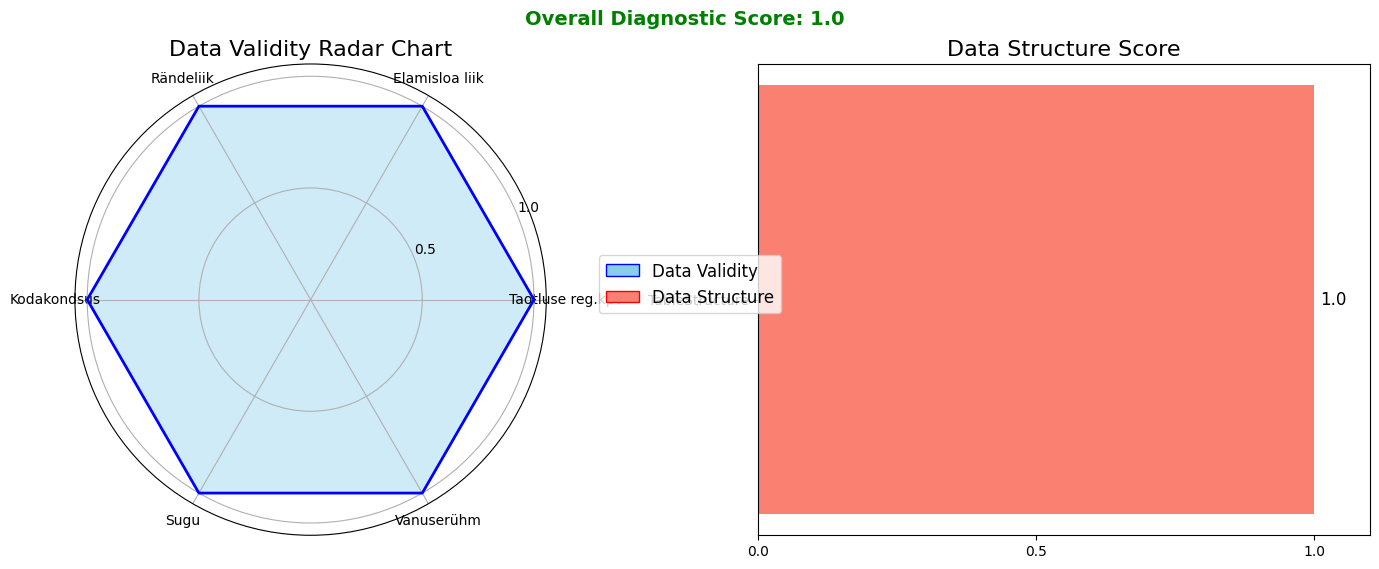

In [ ]:
from diagnostic_report_generator import DiagnosticEvaluator

diagnosticReportGenerator = DiagnosticEvaluator(real_data = processed_data, synthetic_data = generated_data, metadata = metadata, method=synthetic_data_type)
diagnosticReportGenerator.run_diagnostic_realistic()
diagnosticReportGenerator.plot_diagnostic_report_realistic(output_path = output_path)

## KFP Component

In [ ]:
def diagnostic_report(input_synth_csv: comp.InputPath('csv'), input_real_csv: comp.InputPath('csv'), input_json:comp.InputPath('json'), output_html: comp.OutputPath('html')) -> NamedTuple('VisualizationOutput', [('mlpipeline_ui_metadata', 'UI_metadata')]):
    import synthguard.helper_functions as sd
    import json

    with open(output_html, "w") as f:
        f.write("<html><body>")  # Start the HTML document

    #Component logic
    from synthguard.diagnostic_report_generator import DiagnosticEvaluator    
    # from diagnostic_report_generator import DiagnosticEvaluator
    real_data = sd.load_data_csv(input_real_csv)
    synthetic_data = sd.load_data_csv(input_synth_csv)
    metadata = sd.load_metadata(input_json)
    synthetic_data_type = 'realistic'
    
    # diagnosticReportGenerator = DiagnosticEvaluator(real_data = real_data, synthetic_data = generated_data, metadata = metadata, method=synthetic_data_type)
    # diagnosticReportGenerator.run_diagnostic_realistic()
    # diagnosticReportGenerator.plot_diagnostic_report_realistic(output_path = output_path)

    diagnosticReportGenerator = DiagnosticEvaluator(real_data = real_data, synthetic_data = synthetic_data, metadata = metadata, method=synthetic_data_type)
    diagnosticReportGenerator.run_diagnostic_realistic()
    diagnosticReportGenerator.plot_diagnostic_report_realistic()
    diagnosticReportGenerator.save_plot_to_html(output_html)

    # Read the HTML content for UI metadata
    with open(output_html, 'r') as file:
        html_content = file.read()

    metadata = {
        'outputs': [{
            'type': 'web-app',
            'storage': 'inline',
            'source': html_content,
        }]
    }

    from collections import namedtuple
    visualization_output = namedtuple('VisualizationOutput', ['mlpipeline_ui_metadata'])
    return visualization_output(json.dumps(metadata))

# Compiling funtion into a KFP component
diagnostic_component = comp.create_component_from_func(func = diagnostic_report, base_image = 'python:3.10',
                                                       packages_to_install = sg_package)


Error when stripping type annotations: No module named 'lib2to3'


# Utility Report
* The Utiltiy Report checks for statistical similarity between the real and the synthetic data. Use this to discover which patterns the synthetic data has captured from the real data.
    * **Column Shapes:** The statistical similarity between the real and synthetic data for single columns of data. This is often called the marginal distribution of each column.
    * **Column Pair Trends:** The statistical similarity between the real and synthetic data for pairs of columns. This is often called the correlation or bivariate distributions of the columns.
* Population Metrics:
    * **Observed pMSE:** 
    * **Standard pMSE:**
    * **Observed-Null pMSE Ratio:**
    * **Kolmogorov-Smirnov Distance (SPECKS):**

| Metric                         | Description                                                                                      | Range                    | Interpretation                                                                                                        | Better Values                              |
|---------------------------------|--------------------------------------------------------------------------------------------------|--------------------------|----------------------------------------------------------------------------------------------------------------------|--------------------------------------------|
| **Observed pMSE**               | The observed **propensity score mean-squared error** between real and synthetic data.              | $0 \leq \text{pMSE} < \infty$ | Measures how closely the synthetic data mimics the real data in terms of propensity scores.                         | **Lower** values are better. A value of 0 means perfect matching. |
| **Standard pMSE**               | The **null-standardized pMSE**, which compares the observed pMSE to a distribution of pMSEs from a null model (e.g., random permutations). | $0 \leq \text{Standard pMSE} < \infty$ | Indicates how much the observed pMSE deviates from the null distribution. Lower values suggest that the synthetic data closely mimics real data compared to random variations. | **Lower** values are better. |
| **Observed-Null pMSE Ratio**    | The ratio of observed pMSE to the standard pMSE. A ratio of 1 indicates that the observed pMSE is close to the mean of the null distribution. | $0 \leq \text{Ratio} < \infty$ | The higher the ratio, the more the observed pMSE deviates from the null distribution. A ratio of 1 is ideal, indicating that the observed pMSE is not significantly different from the null model. | **Closer to 1** is better. A higher ratio indicates greater deviation from the null model. |
| **Kolmogorov-Smirnov Distance (SPECKS)** | The Kolmogorov-Smirnov distance measures the **difference** between the **Cumulative Distribution Functions (CDFs)** of the real and synthetic data’s propensity scores. | $0 \leq \text{KS distance} \leq 1$ | Measures how closely the real and synthetic data’s propensity score distributions align. A value of 0 means perfect match, and 1 means they are completely different. | **Lower** values are better, with 0 indicating a perfect match. |





Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 69.68it/s]|
Column Shapes Score: 85.35%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 37.43it/s]|
Column Pair Trends Score: 75.86%

Overall Score (Average): 80.6%



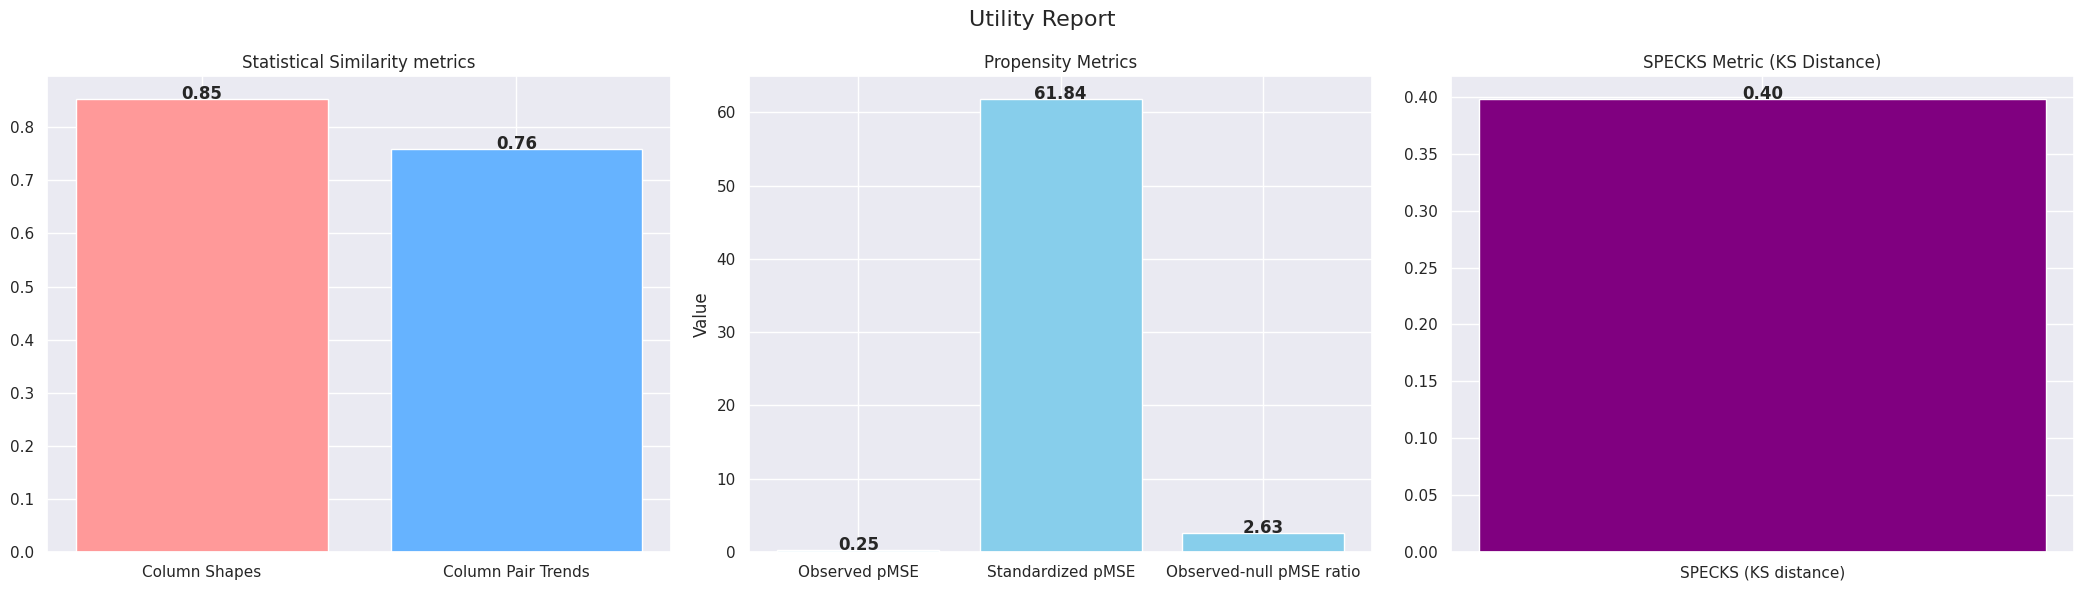

In [ ]:

from quality_report_generator import DataQualityEvaluator

dataQualityEvaluator = DataQualityEvaluator(real_data = processed_data, synthetic_data = generated_data, metadata = metadata, method=synthetic_data_type)
dataQualityEvaluator.evaluate_quality()
dataQualityEvaluator.plot_quality_report_realistic(output_path = output_path)

## KFP Component

In [ ]:
def quality_report(input_synth_csv: comp.InputPath('csv'), input_real_csv: comp.InputPath('csv'), input_json:comp.InputPath('json'), output_html: comp.OutputPath('html')) -> NamedTuple('VisualizationOutput', [('mlpipeline_ui_metadata', 'UI_metadata')]):
    import synthguard.helper_functions as sd
    import json

    with open(output_html, "w") as f:
        f.write("<html><body>")  # Start the HTML document

    #Component logic
    from synthguard.quality_report_generator import DataQualityEvaluator
    real_data = sd.load_data_csv(input_real_csv)
    synthetic_data = sd.load_data_csv(input_synth_csv)
    metadata = sd.load_metadata(input_json)
    synthetic_data_type = 'realistic'
    
        
    dataQualityEvaluator = DataQualityEvaluator(real_data = real_data, synthetic_data = synthetic_data, metadata = metadata, method=synthetic_data_type)
    dataQualityEvaluator.evaluate_quality()
    dataQualityEvaluator.plot_quality_report_realistic()
    dataQualityEvaluator.save_plot_to_html(output_html)

    # Read the HTML content for UI metadata
    with open(output_html, 'r') as file:
        html_content = file.read()

    metadata = {
        'outputs': [{
            'type': 'web-app',
            'storage': 'inline',
            'source': html_content,
        }]
    }

    from collections import namedtuple
    visualization_output = namedtuple('VisualizationOutput', ['mlpipeline_ui_metadata'])
    return visualization_output(json.dumps(metadata))

# Compiling funtion into a KFP component
utility_component = comp.create_component_from_func(func = quality_report, base_image = 'python:3.10', 
                                                    packages_to_install = sg_package)

Error when stripping type annotations: No module named 'lib2to3'


# Privacy Report


| **Privacy Metric**            | **Description**                                                                                                                                                               | **Method**                                                                                             | **Use Cases**                                                                                         | **Pros**                                                                                             | **Cons**                                                                                             | **Range of Values**                  | **Preferred Range**             |
|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|--------------------------------------|---------------------------------|
| **CategoricalCAP**            | Measures the risk of disclosing sensitive information through an inference attack. We assume that some values in the real data are public knowledge. An attacker is combining this with synthetic data to make guesses about other real values that are sensitive. This metric describes how difficult it is for an attacker to correctly guess the sensitive information using an algorithm called Correct Attribution Probability (CAP).                          | Uses key-target relationships in synthetic data based on known features in real data.                 | Ideal for assessing disclosure risk when attackers know certain fields and may infer others.         | Simple yet effective for evaluating conditional privacy risks.                                       | Limited to categorical data; may require specific key/target selection.                              | 0 to 1                                 | **Higher values preferred (closer to 1)**. <br> **Best (1.0):** Real data is 100% protected from the attack (attacker cannot guess sensitive values). <br> **Worst (0.0):** Real data is vulnerable to attack (attacker can guess every sensitive value).    |
| **NewRowSynthesis**           | Assesses privacy by measuring whether each row in the synthetic data is novel, or whether it exactly matches an original row in the real data.    | Calculates row-level matches or minimum distances to identify duplicate or nearly duplicate rows.     | Useful in scenarios where any direct copying of real data into synthetic data poses privacy risks.   | Effective for identifying direct replication risks.                                                  | Limited to row-level exact matches; may overlook nuanced, indirect similarities.                     | 0 to 1                                 | **Higher values preferred (closer to 1)**. <br> **Best (1.0):** All rows in synthetic data are new, with no matches in real data. <br> **Worst (0.0):** Synthetic data contains direct copies of real data rows. |
| **Inference Attacks**         | Evaluates re-identification or attribute inference risks, estimating the likelihood that synthetic data allows sensitive attribute inference through statistical methods. Privacy Against Inference describes a set of metrics that calculate the risk of an attacker being able to infer real, sensitive values. We assume that an attacker already possess a few columns of real data; they will combine it with the synthetic data to make educated guesses.    | Employs statistical/ML models to simulate attacks that deduce sensitive information from known fields. | Used in risk analysis when there is concern that synthetic data could reveal sensitive information.  | Provides broad risk assessment by simulating realistic attacks.                                      | Computationally intensive; results vary depending on the models used.                                | Probability scores (0 to 1)           | **Higher values preferred (closer to 1)**. <br> **Best (1.0):** Real data is safe from attack (attacker cannot correctly guess sensitive values). <br> **Worst (0.0):** Real data is vulnerable to attack (attacker can guess every sensitive value). |
| **TCAP Score**                | Target Correct Attribution Probability (TCAP) measures the risk of correctly attributing sensitive target values based on known key attributes in synthetic data.           | Computes the probability of matching real key-target pairings using the corresponding synthetic data.  | Applies when specific attributes in real data should remain private.                                | Provides targeted privacy risk assessment using key-target pairings.                                  | Limited to categorical data; continuous data must be binned.                                         | 0 to 1                                 | **Lower values preferred (closer to 0)**. |
| **Minimum Nearest-Neighbour** | Measures privacy risk by calculating the closest distance between real and synthetic data points, focusing on potential privacy issues among outlier points in real data. | Computes the minimum distance between real and synthetic data points, optionally filtering outliers.  | Useful where synthetic data should not closely resemble real data, especially protecting outliers.   | Effectively identifies overly close matches in synthetic data.                                       | Sensitive to parameter choices like threshold and outlier settings; assumes ordinal data encoding.   | Normalized distance metric (0 to 1)              | **Higher values preferred**. |
| **Sample Overlap Score**      | Estimates the privacy risk by measuring the percentage overlap between random samples of real and synthetic data.                                                            | Calculates overlap between sampled real and synthetic datasets, as unique or non-unique matches.       | Useful for determining the degree to which synthetic data replicates real data patterns on a sample basis. | Offers a flexible approach to measuring data similarity, adjustable via sampling settings.            | Dependent on sampling and seed choices; requires carefully chosen features for accuracy.             | Percentage overlap (0 to 100%)        | **Lower values preferred (closer to 0%)**. |



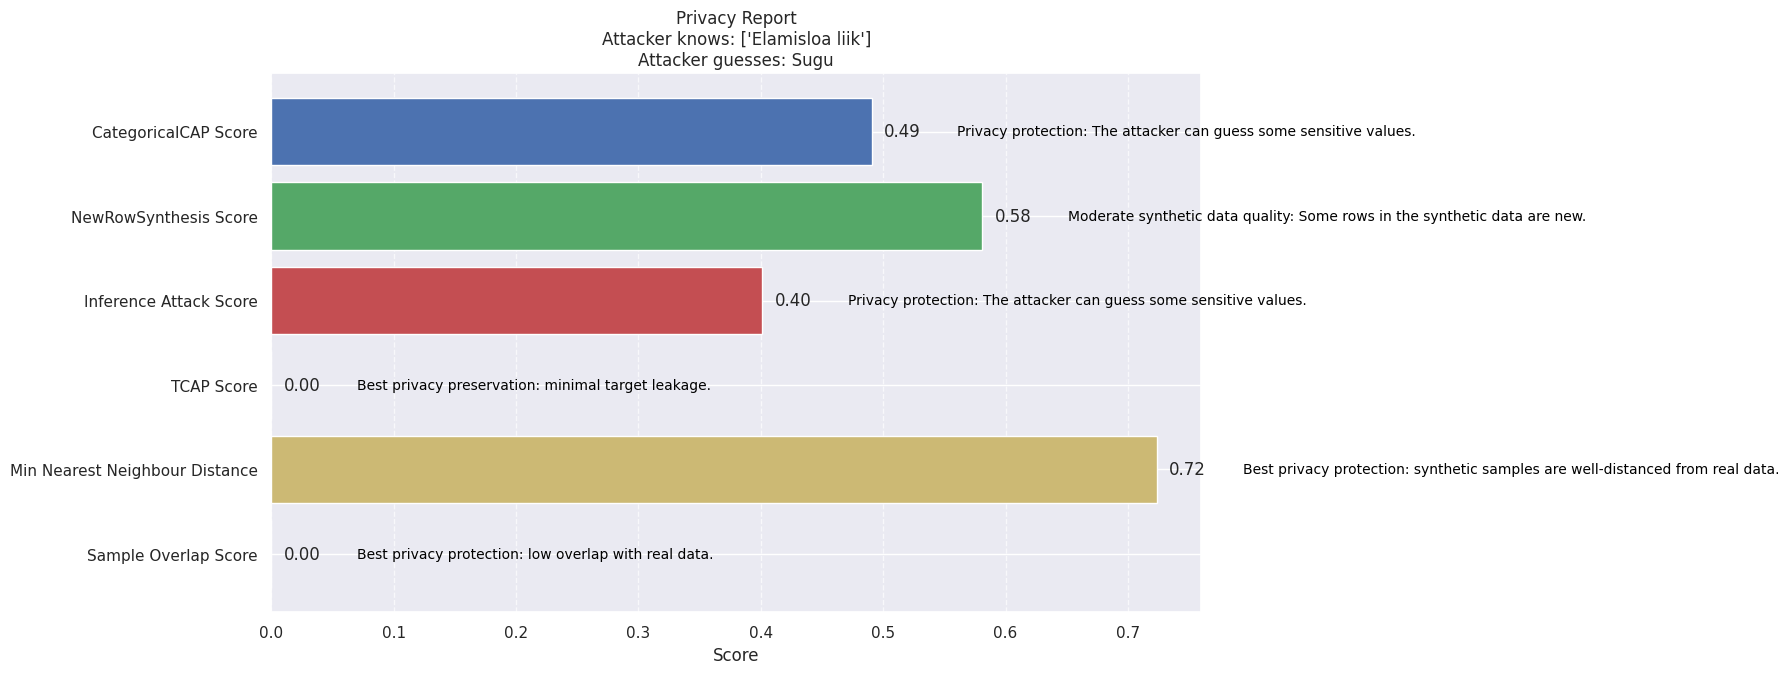

In [ ]:
from privacy_report_generator import PrivacyRiskEvaluator

privacyRiskEvaluator = PrivacyRiskEvaluator(real_data = processed_data, synthetic_data = generated_data, metadata = metadata, method=synthetic_data_type)
privacyRiskEvaluator.run_privacy_realistic()
privacyRiskEvaluator.plot_privacy_metrics_realistic(output_path = output_path)


## KFP Component

In [ ]:
def privacy_report(input_synth_csv: comp.InputPath('csv'), input_real_csv: comp.InputPath('csv'), input_json:comp.InputPath('json'), output_html: comp.OutputPath('html')) -> NamedTuple('VisualizationOutput', [('mlpipeline_ui_metadata', 'UI_metadata')]):
    import synthguard.helper_functions as sd
    import json

    with open(output_html, "w") as f:
        f.write("<html><body>")  # Start the HTML document

    #Component logic
    from synthguard.privacy_report_generator import PrivacyRiskEvaluator
    real_data = sd.load_data_csv(input_real_csv)
    synthetic_data = sd.load_data_csv(input_synth_csv)
    metadata = sd.load_metadata(input_json)
    synthetic_data_type = 'realistic'
    
    
    privacyRiskEvaluator = PrivacyRiskEvaluator(real_data = real_data, synthetic_data = synthetic_data, metadata = metadata, method=synthetic_data_type)
    privacyRiskEvaluator.run_privacy_realistic()
    privacyRiskEvaluator.plot_privacy_metrics_realistic()
    privacyRiskEvaluator.save_plot_to_html(output_html)

    # Read the HTML content for UI metadata
    with open(output_html, 'r') as file:
        html_content = file.read()

    metadata = {
        'outputs': [{
            'type': 'web-app',
            'storage': 'inline',
            'source': html_content,
        }]
    }

    from collections import namedtuple
    visualization_output = namedtuple('VisualizationOutput', ['mlpipeline_ui_metadata'])
    return visualization_output(json.dumps(metadata))


# Compiling funtion into a KFP component
privacy_component = comp.create_component_from_func(func = privacy_report, base_image = 'python:3.10', 
                                                    packages_to_install = sg_package)

Error when stripping type annotations: No module named 'lib2to3'


## KFP Pipeline

In [ ]:
@dsl.pipeline(name='SDG_example_pipeline_mahmoud', description='')
def pipeline(target_utility, target_privacy):
	input = input_component()
	preprocess = preprocess_component(input.output)
	generation = generation_component(target_utility, target_privacy, input.output, preprocess.output)
	dianostic = diagnostic_component(input.output, generation.output, preprocess.output)
	utility = utility_component(input.output, generation.output, preprocess.output)
	privacy = privacy_component(input.output, generation.output, preprocess.output)

In [13]:
Compiler().compile(pipeline, 'LAGO_SDG.yaml')